# DVD Inversion exercise (GNSS and InSAR- Low Noise)

This notebook solves DVD inversion exercises using all the datasets available

## Import libraries

In [20]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util
from vmod.data import Insar
from vmod.data import Gnss
from vmod.data import Joint
from vmod.source import Mctigue

## Read InSAR datasets

In [2]:
xsa,ysa,losa,azsa,incsa=np.loadtxt('examples/dvd/insar/Synth_Asc_Low_Correlated.csv',skiprows=1,delimiter=',',unpack=True)
xsd,ysd,losd,azsd,incsd=np.loadtxt('examples/dvd/insar/Synth_Des_Low_Correlated.csv',skiprows=1,delimiter=',',unpack=True)
azsa=np.radians(azsa)
azsd=np.radians(azsd)
incsa=np.radians(incsa)
incsd=np.radians(incsd)

In [3]:
nx=401
ny=nx
losa=np.reshape(losa,(ny,nx))[:,::-1].T
losd=np.reshape(losd,(ny,nx))[:,::-1].T
azsa=np.reshape(azsa,(ny,nx))[:,::-1].T
azsd=np.reshape(azsd,(ny,nx))[:,::-1].T
incsa=np.reshape(incsa,(ny,nx))[:,::-1].T
incsd=np.reshape(incsd,(ny,nx))[:,::-1].T

In [4]:
extenta=[np.min(xsa),np.max(xsa),np.min(ysa),np.max(ysa)]
extentd=[np.min(xsd),np.max(xsd),np.min(ysd),np.max(ysd)]
#util.mat2quad(losa,azsa,incsa,extenta,name='asc.txt',per=30,unit='m')
#util.mat2quad(losd,azsd,incsd,extentd,name='des.txt',per=30,unit='m')

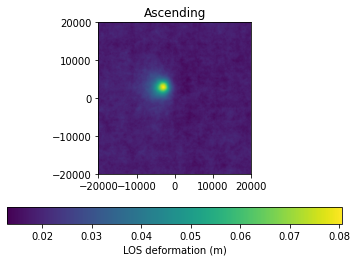

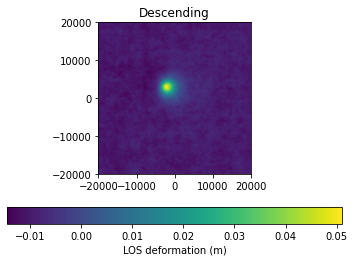

In [5]:
plt.figure()
plt.title('Ascending')
plt.imshow(losa,extent=extenta)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

plt.figure()
plt.title('Descending')
plt.imshow(losd,extent=extentd)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

## Read downsampled datasets

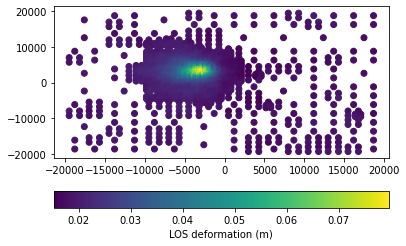

In [6]:
xsa,ysa,azsa,lksa,losa,elosa,refa=util.read_insar_csv('examples/dvd/insar/asc_low.txt')

plt.figure()
plt.scatter(xsa,ysa,c=losa)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

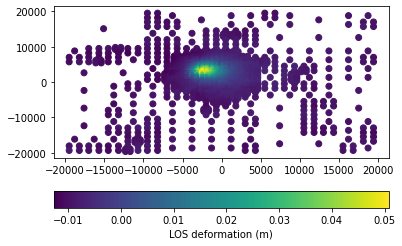

In [7]:
xsd,ysd,azsd,lksd,losd,elosd,refd=util.read_insar_csv('examples/dvd/insar/des_low.txt')

plt.figure()
plt.scatter(xsd,ysd,c=losd)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

## Read GNSS dataset

In [8]:
csvfile='examples/dvd/gps/Synth_ENU_Low_Gaussian.csv'
xsg,ysg,uxs,uys,uzs=np.loadtxt(csvfile,skiprows=1,delimiter=',',unpack=True)
euxs=xsg*0+1e-3
euys=np.copy(euxs)
euzs=np.copy(euxs)
names=[str(i).zfill(4) for i in range(len(xsg))]

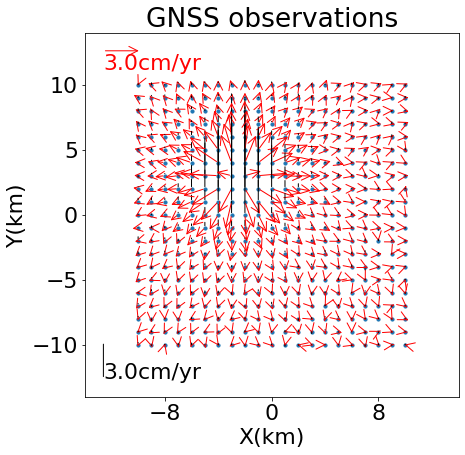

In [29]:
plt.rcParams.update({'font.size': 22})
util.plot_gnss(xsg,ysg,uxs,uys,uzs,title='GNSS observations',scl=3.0,figsize=(6.7,6.7))

## Create joint data object

In [10]:
obsg=Gnss()
obsg.add_names(names)
obsg.add_xs(xsg)
obsg.add_ys(ysg)
obsg.add_ux(uxs)
obsg.add_uy(uys)
obsg.add_uz(uzs)
obsg.add_errx(euxs)
obsg.add_erry(euys)
obsg.add_errz(euzs)

obsa=Insar()
obsa.add_xs(xsa)
obsa.add_ys(ysa)
obsa.add_vecs(azsa,lksa)
obsa.add_los(losa)
obsa.add_err(elosa)
obsa.add_ref([20000,-20000,0,0,'3U'])

obsd=Insar()
obsd.add_xs(xsd)
obsd.add_ys(ysd)
obsd.add_vecs(azsd,lksd)
obsd.add_los(losd)
obsd.add_err(elosd)
obsd.add_ref([20000,-20000,0,0,'3U'])

obs=Joint()
obs.add_dataset(obsa,wt=1.0)
obs.add_dataset(obsd,wt=1.0)
obs.add_dataset(obsg,wt=np.max([len(xsa),len(xsd)])/(2*len(xsg)))

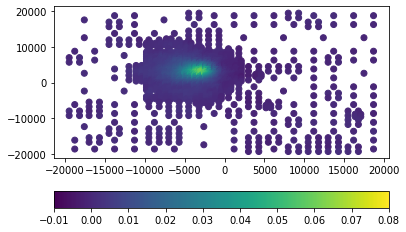

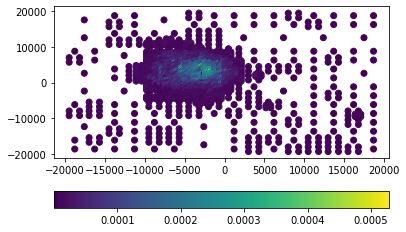

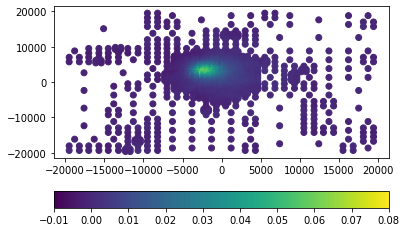

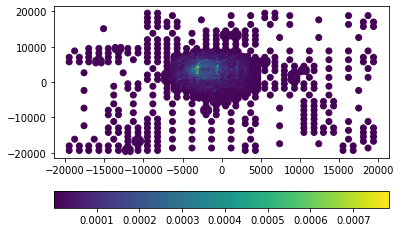

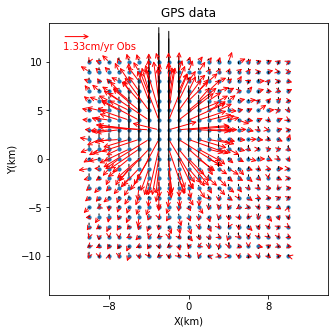

In [11]:
plt.figure()
plt.scatter(xsa,ysa,c=obsa.get_data(),vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsa,ysa,c=elosa)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=obsd.get_data(),vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=elosd)
plt.colorbar(orientation='horizontal')

util.plot_gnss(xsg,ysg,obsg.ux,obsg.uy,obsg.uz)

## Create model objects for each data type

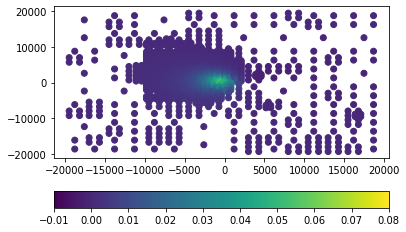

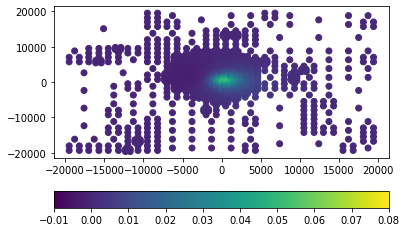

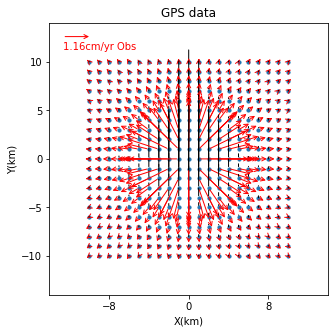

In [12]:
mcta=Mctigue(obsa)
losm=mcta.forward([0,0,2.0e3,5e2,1e6])

plt.figure()
plt.scatter(xsa,ysa,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

mctd=Mctigue(obsd)
losm=mctd.forward([0,0,2.0e3,5e2,1e6])

plt.figure()
plt.scatter(xsd,ysd,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

mctg=Mctigue(obsg)
uxm,uym,uzm=mctg.forward([0,0,2.0e3,5e2,1e6],unravel=False)
util.plot_gnss(xsg,ysg,uxm,uym,uzm)

## Create model object for joint dataset

In [13]:
mct=Mctigue(obs)
mct.set_x0([0,0,2e3,5e2,1e6])
#Bounds for parameters
mct.set_bounds(low_bounds = [-20000,-20000,1e2,1e2,1e5], high_bounds = [20000,20000,9e4,5e3,1e8])

## Create Inversion object

In [14]:
from vmod.inverse import Inverse

inv=Inverse(obs)
inv.register_source(mct)

## Least-squares inversion

In [15]:
ans=inv.nlsq()

print(ans.x)

0.08232260063084201
[-2.51705262e+03  2.87286669e+03  2.18443737e+03  1.01447307e+03
  1.27398680e+06]


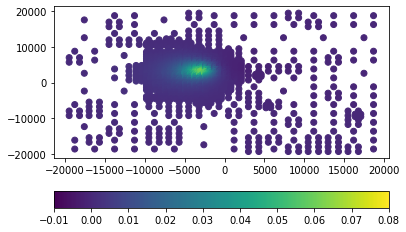

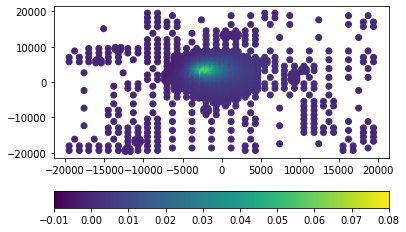

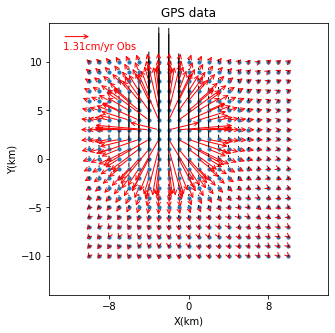

In [16]:
losm=mcta.forward(ans.x)

plt.figure()
plt.scatter(xsa,ysa,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

losm=mctd.forward(ans.x)

plt.figure()
plt.scatter(xsd,ysd,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

uxm,uym,uzm=mctg.forward(ans.x,unravel=False)
util.plot_gnss(xsg,ysg,uxm,uym,uzm)

## Bayesian Inversion

In [17]:
trace,MDL=inv.mcmc('joint_low')

 [-----------------100%-----------------] 1100000 of 1100000 complete in 9518.9 sec

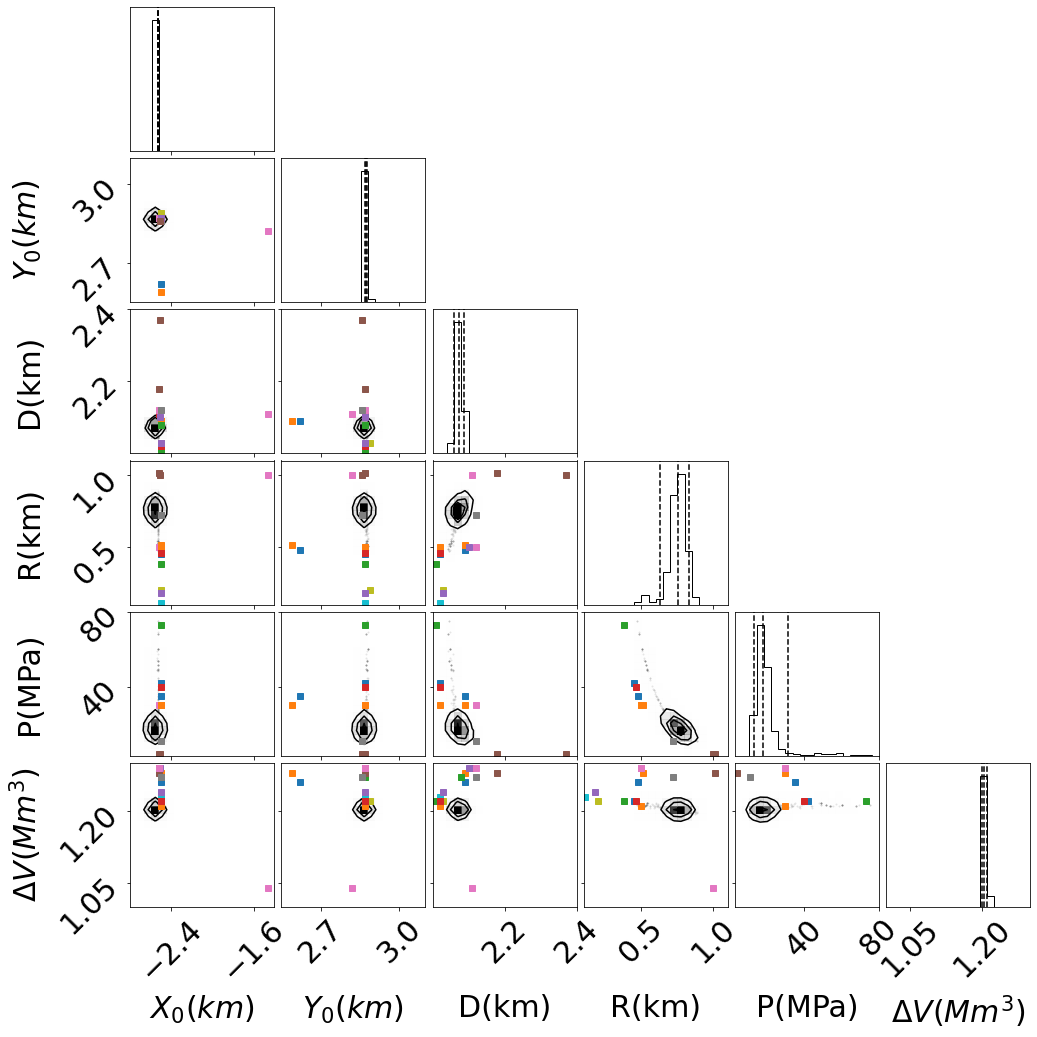

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)
newdata=np.zeros((data.shape[0]+1,data.shape[1]))
newdata[:,:]=np.nan
newdata[0:4,:]=np.copy(data[0:4,:])
newdata[4,:]=np.copy(data[4,:]*2e10/(np.pi*data[3,:]**3))
newdata[5,:]=np.copy(data[4,:])

data=np.copy(newdata)
data[0,:]=data[0,:]/1e3
data[1,:]=data[1,:]/1e3
data[2,:]=data[2,:]/1e3
data[3,:]=data[3,:]/1e3
data[4,:]=data[4,:]/1e6
data[5,:]=data[5,:]/1e6
labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','P(MPa)','$\Delta{V} (Mm^{3})$']

trus1=[-2.50,2.62,2.09,0.48,35,1.26]
trus2=[-2.50,2.59,2.09,0.51,30,1.28]
trus3=[-2.50,2.87,2.08,0,0,1.27]
trus4=[-2.52,2.87,2.11,0,0,1.29]
trus5=[-2.51,2.87,2.10,0.5,0,1.29]
trus6=[-2.52,2.87,2.18,1.01,4,1.28]
trus7=[-2.52,2.87,2.12,0.50,30,1.29]
trus8=[-2.50,2.86,2.12,0.72,11,1.27]
trus9=[-2.50,2.89,2.03,0.20,484,1.22]
trus10=[-2.50,2.87,2.02,0.11,3340,1.23]
trus11=[-2.50,2.87,2.02,0.45,42,1.22]
trus12=[-2.50,2.87,2.02,0.50,30,1.21]
trus13=[-2.50,2.87,2.01,0.38,73,1.22]
trus14=[-2.50,2.87,2.02,0.46,40,1.22]
trus15=[-2.50,2.87,2.03,0.18,710,1.24]
trus16=[-2.51,2.86,2.37,1.00,4,0]
trus17=[-1.46,2.82,2.11,1.00,0,1.04]

trus=[trus1,trus2,trus3,trus4,trus5,trus6,trus7,trus8,trus9,trus10,trus11,trus12,trus13,trus14,trus15,trus16,trus17]

ranges=[(-2.8,-1.40),(2.55,3.1),(2.0,2.4),(0.1,1.1),(3,80),(1.0,1.3)]

plt.rcParams.update({'font.size': 30})
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],smooth=0.7,range=ranges,max_n_ticks=2,labelpad=0.3,
                       show_titles=False, label_kwargs={"fontsize": 30}, title_kwargs={"fontsize": 30})

for i,tru in enumerate(trus):
    #corner.overplot_lines(figure, np.array(tru), color="C"+str(i),linewidth=1)
    corner.overplot_points(figure, np.array(tru)[None], color="C"+str(i),marker='s')

plt.savefig('histograms')

## Calculation of percentiles to upload the results

In [22]:
means=[np.percentile(data[i,:],50) for i in range(data.shape[0])]
lower95=[np.percentile(data[i,:],5) for i in range(data.shape[0])]
upper95=[np.percentile(data[i,:],95) for i in range(data.shape[0])]
lower32=[np.percentile(data[i,:],32) for i in range(data.shape[0])]
upper68=[np.percentile(data[i,:],68) for i in range(data.shape[0])]

results=[means,lower95,upper95,lower32,upper68]

for res in results:
    for i in range(len(res)):
        if i in [0,1,2,3]:
            res[i]=res[i]*1e3
        elif i in [4,5]:
            res[i]=res[i]*1e6
        elif i in [6,7]:
            res[i]=res[i]/1e2
    print("%4.0f,%4.0f,%4.0f,%3.0f,%2.0f,%2.0f"%(tuple(res)))


-2528,2875,2074,755,17811714,1204808
-2533,2870,2058,627,13219192,1198782
-2524,2879,2087,833,31211271,1210856
-2530,2873,2071,730,16382988,1203107
-2527,2876,2078,776,19734036,1206515


[-2.52841858e+03  2.87457100e+03  2.07444478e+03  7.55227530e+02
  1.20480778e+06]


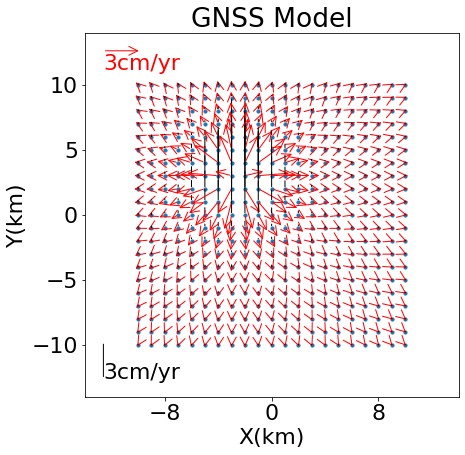

In [23]:
plt.rcParams.update({'font.size': 22})
xbest=np.array([np.median(data[0,:])*1e3,np.median(data[1,:])*1e3,np.median(data[2,:])*1e3,np.median(data[3,:])*1e3,np.median(data[5,:])*1e6])
print(xbest)
uxsm,uysm,uzsm=mctg.forward(xbest,unravel=False)
plt.rcParams.update({'font.size': 22})
util.plot_gnss(xsg,ysg,uxsm,uysm,uzsm,title='GNSS Model',scl=3,figsize=(6.7,6.7))

[-2.52841858e+03  2.87457100e+03  2.07444478e+03  7.55227530e+02
  1.20480778e+06] [-2.52841858e+03  2.87457100e+03  2.07444478e+03  7.55227530e+02
  1.20480778e+06]


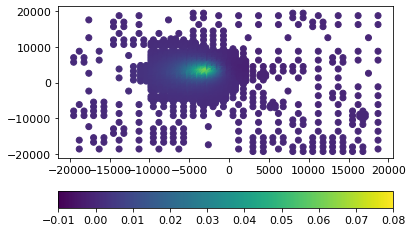

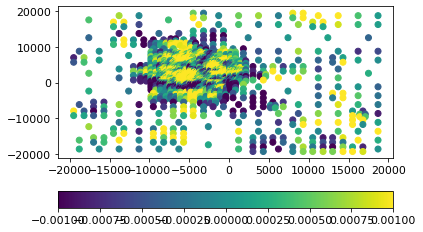

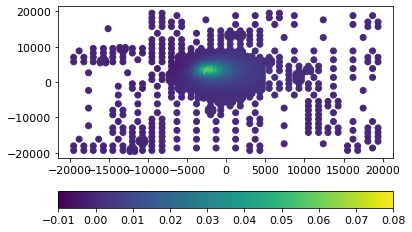

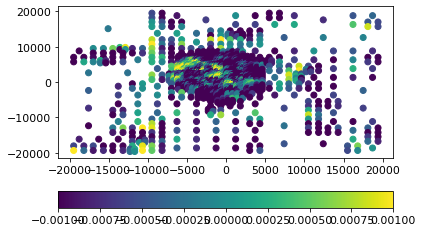

In [24]:
plt.rcParams.update({'font.size': 11})
ansa=np.concatenate((means[0:4],[means[5]]))
ansd=np.concatenate((means[0:4],[means[5]]))

print(ansa,ansd)

losma=mcta.forward(ansa)

plt.figure()
plt.scatter(xsa,ysa,c=losma,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsa,ysa,c=obsa.get_data()-losma,vmin=-1e-3,vmax=1e-3)
plt.colorbar(orientation='horizontal')

losmd=mctd.forward(ansd)

plt.figure()
plt.scatter(xsd,ysd,c=losmd,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=obsd.get_data()-losmd,vmin=-1e-3,vmax=1e-3)
plt.colorbar(orientation='horizontal')

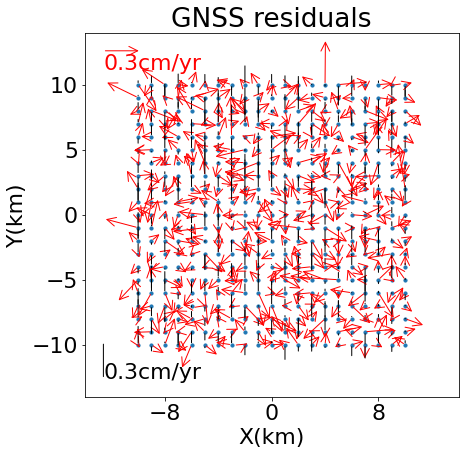

In [30]:
util.plot_gnss(xsg,ysg,uxs-uxsm,uys-uysm,uzs-uzsm,title='GNSS residuals',scl=0.3,figsize=(6.7,6.7))

Text(0, 0.5, 'Y(km)')

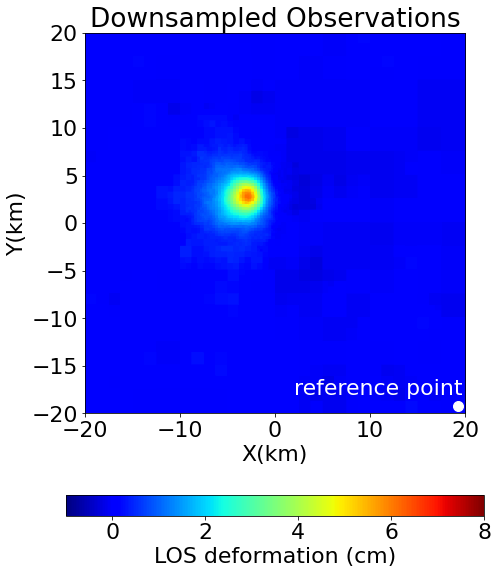

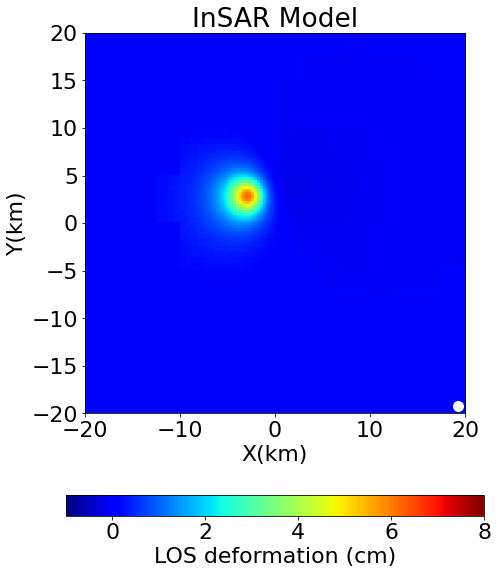

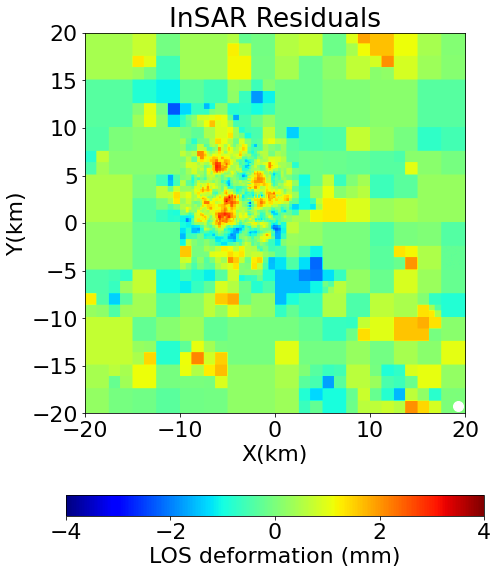

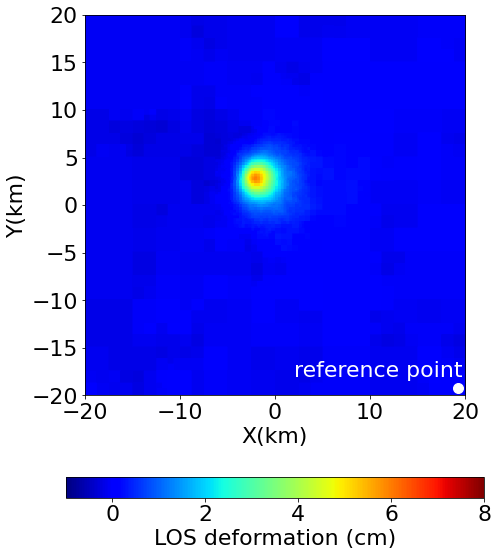

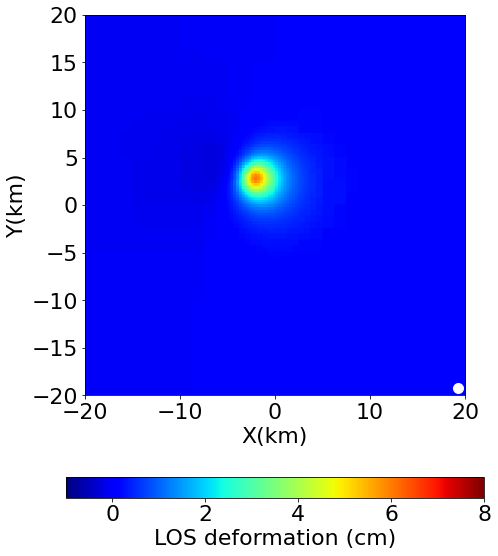

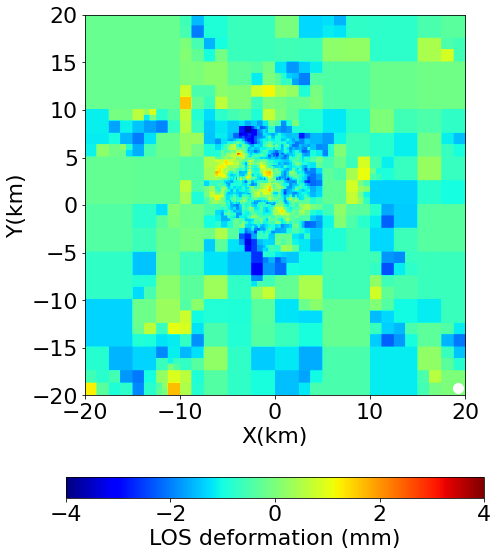

In [28]:
plt.rcParams.update({'font.size': 22})

qmapa,extent=util.los2npy(obsa.get_data(),'examples/dvd/insar/asc_low.txt',cref=False)

plt.figure(figsize=(10,10))
plt.title('Downsampled Observations')
plt.imshow(qmapa*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.scatter([19.2],[-19.2],c='white',s=100)
plt.text(2,-18,s='reference point',c='white')
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapma,extent=util.los2npy(losma,'examples/dvd/insar/asc_low.txt',cref=False)

plt.figure(figsize=(10,10))
plt.title('InSAR Model')
plt.imshow(qmapma*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.scatter([19.2],[-19.2],c='white',s=100)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
plt.title('InSAR Residuals')
plt.imshow(qmapa*1e3-qmapma*1e3,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-4,vmax=4,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (mm)',shrink=0.75)
plt.scatter([19.2],[-19.2],c='white',s=100)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')


qmapd,extent=util.los2npy(obsd.get_data(),'examples/dvd/insar/des_low.txt',cref=False)

plt.figure(figsize=(10,10))
#plt.title('Downsampled observations')
plt.imshow(qmapd*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.scatter([19.2],[-19.2],c='white',s=100)
plt.text(2,-18,s='reference point',c='white')
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapmd,extent=util.los2npy(losmd,'examples/dvd/insar/des_low.txt',cref=False)

plt.figure(figsize=(10,10))
#plt.title('Model')
plt.imshow(qmapmd*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.scatter([19.2],[-19.2],c='white',s=100)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
#plt.title('Residuals')
plt.imshow((qmapd-qmapmd)*1e3,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-4,vmax=4,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (mm)',shrink=0.75)
plt.scatter([19.2],[-19.2],c='white',s=100)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')